In [1]:
import numpy as np
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot_ng as pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
import kt_utils 

import keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

%matplotlib inline


Using TensorFlow backend.


## 加载数据

In [3]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = kt_utils.load_dataset()

# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Reshape
Y_train = Y_train_orig.T
Y_test = Y_test_orig.T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 600
number of test examples = 150
X_train shape: (600, 64, 64, 3)
Y_train shape: (600, 1)
X_test shape: (150, 64, 64, 3)
Y_test shape: (150, 1)


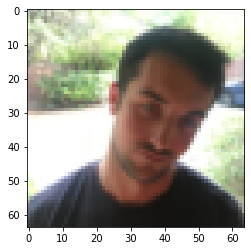

In [4]:
plt.imshow(X_train[0])

## 建立模型

In [5]:
def model(input_shape):
    """
        实现一个检测笑容的模型

        参数：
            input_shape - 输入的数据的维度
        返回：
            model - 创建的Keras的模型
    """
    # 定义placeholder
    X_input = Input(input_shape)
    
    # Padding
    X = ZeroPadding2D((3,3))(X_input)
    
    # 卷积层
    X = Conv2D(32,(7,7),strides=(1,1),name="conv0")(X)
    X = BatchNormalization(axis=3,name="BN0")(X)
    X = Activation("relu")(X)
    
    # 池化层
    X = MaxPooling2D((2,2),name = "max_pool")(X)
    
    # 展开
    X = Flatten()(X)
    
    # fc层
    X = Dense(1,activation="sigmoid",name="fc")(X)
    
    model = Model(inputs=X_input, outputs=X,name="Happyface")
    
    return model

In [10]:
happy_model = model(X_train[0].shape)
# 编译模型
happy_model.compile("adam","binary_crossentropy",metrics=["accuracy"])

happy_model.fit(X_train, Y_train, epochs=40, batch_size=50)
#评估模型
preds = happy_model.evaluate(X_test, Y_test, batch_size=32, verbose=1, sample_weight=None)
print ("误差值 = " + str(preds[0]))
print ("准确度 = " + str(preds[1]))

Epoch 1/40
600/600 [==============================] - 5s 8ms/step - loss: 1.0585 - acc: 0.6650
Epoch 2/40
600/600 [==============================] - 5s 8ms/step - loss: 0.4038 - acc: 0.8217
Epoch 3/40
600/600 [==============================] - 4s 7ms/step - loss: 0.2225 - acc: 0.9133
Epoch 4/40
600/600 [==============================] - 4s 7ms/step - loss: 0.1792 - acc: 0.9267
Epoch 5/40
600/600 [==============================] - 4s 7ms/step - loss: 0.1330 - acc: 0.9633
Epoch 6/40
600/600 [==============================] - 5s 8ms/step - loss: 0.0981 - acc: 0.9683
Epoch 7/40
600/600 [==============================] - 5s 8ms/step - loss: 0.0721 - acc: 0.9833
Epoch 8/40
600/600 [==============================] - 4s 7ms/step - loss: 0.0677 - acc: 0.9817
Epoch 9/40
600/600 [==============================] - 4s 7ms/step - loss: 0.0675 - acc: 0.9817
Epoch 10/40
600/600 [==============================] - 4s 7ms/step - loss: 0.0633 - acc: 0.9867
Epoch 11/40
600/600 [============================

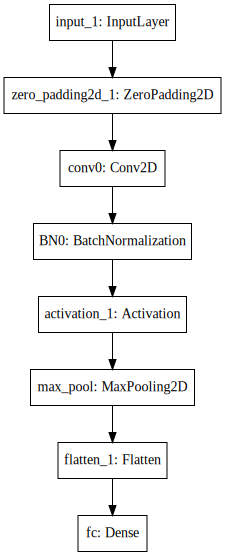

In [8]:
%matplotlib inline
plot_model(happy_model, to_file='happy_model.png')
SVG(model_to_dot(happy_model).create(prog='dot', format='svg'))

## 残差网络

In [1]:
import numpy as np
import tensorflow as tf

from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform

import pydot
from IPython.display import SVG
import scipy.misc
from matplotlib.pyplot import imshow
import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

import resnets_utils 


Using TensorFlow backend.


In [2]:
def identity_block(X, f, filters, stage, block):
    """
        参数：
            X - 输入的tensor类型的数据，维度为（m，H_prev, W_prev, C_prev）
            f - 指定主路经CONV的窗口维度
            fiter - 指定三个过滤器的个数，列表
            stage - 根据每层位置来命名每一层，与block联用
            block - 过呢据每层的位置来命名每一层，与stage联用
            
        返回：
            X - 恒等块的输出，tensor类型，维度为（m，n_H, n_W, n_C）
    """
    conv_name_base = "res" + str(stage) + block + "_brach"
    bn_name_base = "bn" + str(stage) +block + "_branch"
    
    #获取过滤器
    F1,F2,F3 = filters
    
    # 保存输入数据，用于跳远路径中使用
    X_shortcut = X
    
    # 主路经第一部分
    ## 卷积层
    X = Conv2D(filters = F1, kernel_size = (1,1), strides = (1,1), padding="valid",\
              name = conv_name_base+"2a",kernel_initializer = glorot_uniform(seed=0))(X)
    ## BN层
    X = BatchNormalization(axis=3, name = bn_name_base+"2a")(X)
    ## 激活
    X = Activation("relu")(X)
    
    # 主路经第二部分
    ## 卷积层
    X = Conv2D(filters = F2, kernel_size = (f,f), strides = (1,1), padding="same",\
              name = conv_name_base+"2b", kernel_initializer = glorot_uniform(seed=0))(X)
    ## BN层
    X = BatchNormalization(axis=3, name = bn_name_base+"2b")(X)
    ## 激活层
    X = Activation("relu")(X)
    
        # 主路经第三部分
    ## 卷积层
    X = Conv2D(filters = F3, kernel_size = (1,1), strides = (1,1), padding="valid",\
              name = conv_name_base+"2c",kernel_initializer = glorot_uniform(seed=0))(X)
    ## BN层
    X = BatchNormalization(axis=3, name = bn_name_base+"2c")(X)
 
    # 将跳远路径和该层输出融合一下
    X = Add()([X, X_shortcut])
    ## 激活层
    X = Activation("relu")(X)
    
    return X

In [4]:
## 测试
tf.reset_default_graph()
with tf.Session() as test:
    np.random.seed(1)
    A_prev = tf.placeholder("float",[3,4,4,6])
    X = np.random.randn(3,4,4,6)
    A = identity_block(A_prev,f=2,filters=[2,4,6],stage=1,block="a")
    
    test.run(tf.global_variables_initializer())
    out = test.run([A],feed_dict={A_prev:X,K.learning_phase():0})
    print("out = " + str(out[0][1][1][0]))
    
    test.close()


out = [0.94822997 0.         1.1610146  2.747859   0.         1.36677   ]


In [5]:
# 为了适配主路经和捷径的维度匹配需要通过1*1的过滤器进行调整
def convolutional_block(X, f, filters, stage, block, s=2):
    """
        参数：
            X - 输入的tensor类型的数据，维度为（m，H_prev, W_prev, C_prev）
            f - 指定主路经CONV的窗口维度
            fiter - 指定三个过滤器的个数，列表
            stage - 根据每层位置来命名每一层，与block联用
            block - 过呢据每层的位置来命名每一层，与stage联用
            s - 指定步幅，用于匹配维度
            
        返回：
            X - 恒等块的输出，tensor类型，维度为（m，n_H, n_W, n_C）
    """
    conv_name_base = "res" + str(stage) + block + "_brach"
    bn_name_base = "bn" + str(stage) +block + "_branch"
    
    #获取过滤器
    F1,F2,F3 = filters
    
    # 保存输入数据，用于跳远路径中使用
    X_shortcut = X
    
    # 主路经第一部分
    ## 卷积层
    X = Conv2D(filters = F1, kernel_size = (1,1), strides = (s,s), padding="valid",\
              name = conv_name_base+"2a",kernel_initializer = glorot_uniform(seed=0))(X)
    ## BN层
    X = BatchNormalization(axis=3, name = bn_name_base+"2a")(X)
    ## 激活
    X = Activation("relu")(X)
    
    # 主路经第二部分
    ## 卷积层
    X = Conv2D(filters = F2, kernel_size = (f,f), strides = (1,1), padding="same",\
              name = conv_name_base+"2b", kernel_initializer = glorot_uniform(seed=0))(X)
    ## BN层
    X = BatchNormalization(axis=3, name = bn_name_base+"2b")(X)
    ## 激活层
    X = Activation("relu")(X)
    
        # 主路经第三部分
    ## 卷积层
    X = Conv2D(filters = F3, kernel_size = (1,1), strides = (1,1), padding="valid",\
              name = conv_name_base+"2c",kernel_initializer = glorot_uniform(seed=0))(X)
    ## BN层
    X = BatchNormalization(axis=3, name = bn_name_base+"2c")(X)
    
    ## 捷径
    X_shortcut = Conv2D(filters = F3, kernel_size = (1,1), strides = (s,s), padding="valid",\
              name = conv_name_base+"1",kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    ## BN层
    X_shortcut = BatchNormalization(axis=3, name = bn_name_base+"1")(X_shortcut)
    # 将跳远路径和该层输出融合一下
    X = Add()([X, X_shortcut])
    ## 激活层
    X = Activation("relu")(X)
    
    return X

In [6]:
tf.reset_default_graph()

with tf.Session() as test:
    np.random.seed(1)
    A_prev = tf.placeholder("float",[3,4,4,6])
    X = np.random.randn(3,4,4,6)
    
    A = convolutional_block(A_prev,f=2,filters=[2,4,6],stage=1,block="a")
    test.run(tf.global_variables_initializer())
    
    out = test.run([A],feed_dict={A_prev:X,K.learning_phase():0})
    print("out = " + str(out[0][1][1][0]))
    
    test.close()


out = [0.09018461 1.2348979  0.4682202  0.03671762 0.         0.65516603]


In [7]:
# ResNet 50
def ResNet50(input_shape=(64,64,3),classes = 6):
    
    """
        实现ResNet50
        CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
        -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

        参数：
            input_shape - 图像数据集的维度
            classes - 整数，分类数

        返回：
            model - Keras框架的模型
    """
    X_input = Input(input_shape)
    
    X = ZeroPadding2D((3,3))(X_input)
    
    #stage1
    X = Conv2D(filters = 64, kernel_size=(7,7), strides=(2,2),name = "conv1",
              kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name="bn_conv1")(X)
    X = Activation("relu")(X)
    X = MaxPooling2D(pool_size=(3,3),strides=(2,2))(X)
    
    #stage2
    X = convolutional_block(X, f=3, filters=[64,64,256], stage=2, block="a", s=1)
    X = identity_block(X, f=3, filters=[64,64,256], stage=2, block="b")
    X = identity_block(X, f=3, filters=[64,64,256], stage=2, block="c")
    
    #stage3
    X = convolutional_block(X, f=3, filters=[128,128,512], stage=3, block="a", s=2)
    X = identity_block(X, f=3, filters=[128,128,512], stage=3, block="b")
    X = identity_block(X, f=3, filters=[128,128,512], stage=3, block="c")
    X = identity_block(X, f=3, filters=[128,128,512], stage=3, block="d")
    
    #stage4
    X = convolutional_block(X, f=3, filters=[256,256,1024], stage=4, block="a", s=2)
    X = identity_block(X, f=3, filters=[256,256,1024], stage=4, block="b")
    X = identity_block(X, f=3, filters=[256,256,1024], stage=4, block="c")
    X = identity_block(X, f=3, filters=[256,256,1024], stage=4, block="d")
    X = identity_block(X, f=3, filters=[256,256,1024], stage=4, block="e")
    X = identity_block(X, f=3, filters=[256,256,1024], stage=4, block="f")
    
    #stage5
    X = convolutional_block(X, f=3, filters=[512,512,2048], stage=5, block="a", s=2)
    X = identity_block(X, f=3, filters=[512,512,2048], stage=5, block="b")
    X = identity_block(X, f=3, filters=[512,512,2048], stage=5, block="c")
    
    #均值池化层
    X = AveragePooling2D(pool_size=(2,2),padding="same")(X)
    
    #输出层
    X = Flatten()(X)
    X = Dense(classes, activation="softmax", name="fc"+str(classes),
              kernel_initializer=glorot_uniform(seed=0))(X)
    
    
    #创建模型
    model = Model(inputs=X_input, outputs=X, name="ResNet50")
    
    return model

    

In [8]:
model = ResNet50(input_shape=(64,64,3),classes=6)

model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["acc"])  

In [9]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = resnets_utils.load_dataset()

# Normalize image vectors
X_train = X_train_orig / 255.
X_test = X_test_orig / 255.

# Convert training and test labels to one hot matrices
Y_train = resnets_utils.convert_to_one_hot(Y_train_orig, 6).T
Y_test = resnets_utils.convert_to_one_hot(Y_test_orig, 6).T

print("number of training examples = " + str(X_train.shape[0]))
print("number of test examples = " + str(X_test.shape[0]))
print("X_train shape: " + str(X_train.shape))
print("Y_train shape: " + str(Y_train.shape))
print("X_test shape: " + str(X_test.shape))
print("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


In [10]:
model.fit(X_train,Y_train,epochs=10,batch_size=32)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10

1080/1080 [==============================] - 130s 121ms/step - loss: 2.9812 - acc: 0.2648
Epoch 2/10
1080/1080 [==============================] - 120s 112ms/step - loss: 2.6421 - acc: 0.3120
Epoch 3/10
1080/1080 [==============================] - 120s 111ms/step - loss: 2.2027 - acc: 0.3750
Epoch 4/10
1080/1080 [==============================] - 110s 102ms/step - loss: 2.2344 - acc: 0.4250
Epoch 5/10
1080/1080 [==============================] - 115s 107ms/step - loss: 1.4301 - acc: 0.4991
Epoch 6/10
1080/1080 [==============================] - 113s 104ms/step - loss: 0.9398 - acc: 0.6296
Epoch 7/10
1080/1080 [==============================] - 116s 108ms/step - loss: 0.6446 - acc: 0.7713
Epoch 8/10
1080/1080 [==============================] - 134s 124ms/step - loss: 0.6582 - acc: 0.7907
Epoch 9/10
1080/1080 [==============================] - 126s 117ms/step - loss: 0.5069 - acc: 0

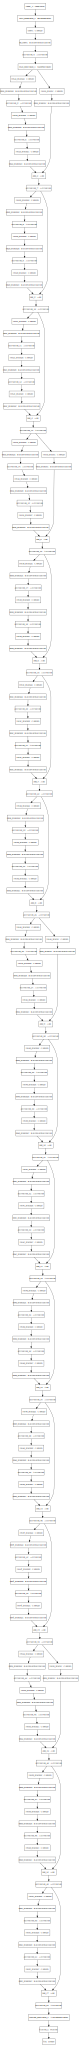

In [11]:
plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))